In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
%matplotlib inline
import io

In [65]:
#hide_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [45]:
df = pd.read_csv('data/cleaned_ca.csv')
p_df_75 = pd.read_csv(io.StringIO(pd.read_csv('data/principal_component_df.csv').to_csv(index=False)), index_col=0)
p_df_100 = pd.read_csv(io.StringIO(pd.read_csv('data/principal_component_df100.csv').to_csv(index=False)), index_col=0)
p_df_75 = pd.read_csv(io.StringIO(p_df_75.to_csv(index=False)))
X = pd.read_csv(io.StringIO(pd.read_csv('data/X.csv').to_csv(index=False)), index_col=0)
y = pd.read_csv(io.StringIO(pd.read_csv('data/y.csv').to_csv(index=False)), index_col=0)
y = pd.read_csv(io.StringIO(y.to_csv(index=False)))
X = pd.read_csv(io.StringIO(X.to_csv(index=False)))

## Random Forest 2

In [48]:
#hide_output
y = y.pop('NMU')
# Train test split
Xp75_train, Xp75_test, yp75_train, yp75_test = train_test_split(p_df_75, y, test_size=0.2, random_state=42, shuffle=True)
assert(len(Xp75_train) == len(yp75_train))
assert(len(Xp75_test) == len(yp75_test))

In [51]:
yp_75_train

7864    1
1095    1
3125    0
9860    0
1561    1
       ..
5734    0
5191    1
5390    0
860     0
7270    0
Name: NMU, Length: 8005, dtype: int64

In [54]:
#hide_input
rnd_clf = RandomForestClassifier(criterion='gini',max_depth=16,max_features='auto',max_leaf_nodes=64,n_estimators= 4000,n_jobs=-1, random_state=27)
rnd_clf.fit(Xp75_train, yp75_train)

RandomForestClassifier(max_depth=16, max_leaf_nodes=64, n_estimators=4000,
                       n_jobs=-1, random_state=27)

In [55]:
y_test_pred = rnd_clf.predict(Xp75_test)
test_acc = np.sum(y_test_pred == yp75_test)/len(yp75_test)
print ("\nAUC - ROC : ", roc_auc_score(yp75_test,rnd_clf.predict(Xp75_test)))
print("test accuracy: "+str(test_acc))


AUC - ROC :  0.6096536374087641
test accuracy: 0.7192807192807192


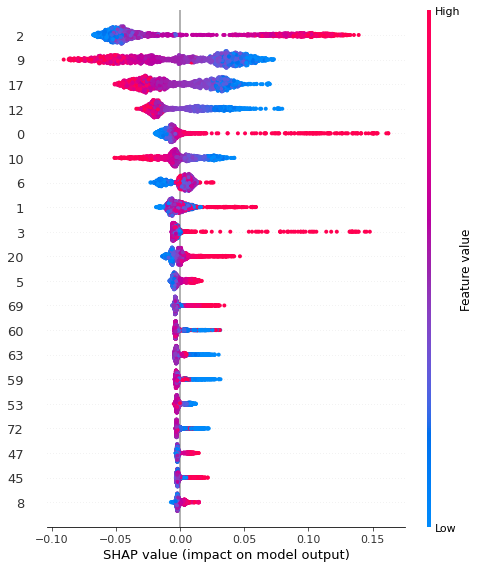

In [56]:
explainer = shap.TreeExplainer(rnd_clf)
shap_values = explainer.shap_values(Xp75_test)
shap.summary_plot(shap_values[1], Xp75_test)

array([[1257,   67],
       [ 495,  183]], dtype=int64)

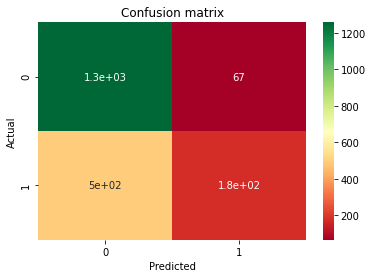

In [62]:
#hide_input
conf_mat = confusion_matrix(yp75_test, y_test_pred)
# all_resp = np.add(np.add(np.add(conf_mat, resp_1),np.add(resp_2, resp_3)),resp_4)
sns.heatmap(conf_mat, cmap="RdYlGn", annot=True).set_title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
conf_mat

Some hint of bias towards 0 as NMU 

## Nueral Network

In [63]:
def create_mlp(
    num_columns, num_labels, hidden_units, dropout_rates, label_smoothing, learning_rate
):

    inp = tf.keras.layers.Input(shape=(num_columns,))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 1])(x)
    x = tf.keras.layers.Dense(num_labels)(x)
    out = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
        metrics=tf.keras.metrics.AUC(name="AUC"),
    )
    return model

In [68]:
yp75_train.shape

(8005,)

In [66]:
#hide_output
batch_size = 124
hidden_units = [150, 150, 150]
dropout_rates = [0.20, 0.20, 0.20, 0.20]
label_smoothing = 1e-2
learning_rate = 3e-3

#with tpu_strategy.scope():
clf = create_mlp(
        Xp75_train.shape[1], 5, hidden_units, dropout_rates, label_smoothing, learning_rate
    )

clf.fit(Xp75_train, yp75_train, epochs=10, batch_size=batch_size)

models.append(clf)

Epoch 1/10


ValueError: in user code:

    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\tonyl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 5) vs (None, 1))
